TensorBoard提供了PROJECTOR界面来可视化高维向量之间的关系。使用PROJECTOR要求转呗一个sprite图像和一个tsv文件给出每张图片对应的标签信息。所谓sprite图像就是将一组图片组合成一整张大图片。<br/>
使用mnist测试数据生成PROJECTOR所需的两个文件：

Extracting ../Data/train-images-idx3-ubyte.gz
Extracting ../Data/train-labels-idx1-ubyte.gz
Extracting ../Data/t10k-images-idx3-ubyte.gz
Extracting ../Data/t10k-labels-idx1-ubyte.gz


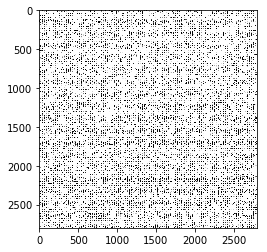

In [12]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from tensorflow.examples.tutorials.mnist import input_data

# PROJECTOR所需的日志文件名和地址相关参数
LOG_DIR = "./log6"
SPRITE_FILE = "mnist_sprite.jpg"
META_FILE = "mnist_meta.tsv"

# 使用给出的MNIST图片列表生成sprite图像
def create_sprite_image(images):
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    m = int(np.ceil(np.sqrt(images.shape[0])))
    
    # 使用全1来初始化最终的大图片
    sprite_image = np.ones((img_h*m, img_w*m))
    
    for i in range(m):
        for j in range(m):
            # 计算当前图片的编号
            cur = i * m + j
            if cur < images.shape[0]:
                # 将当前小图片的内容复制到最终的sprite图像
                sprite_image[i*img_h: (i+1)*img_h, 
                             j*img_w: (j+1)*img_w] = images[cur]
    return sprite_image
# 加载MNIST数据
mnist = input_data.read_data_sets("../Data", one_hot=True)
# 生成sprite图像
to_visualise = 1 - np.reshape(mnist.test.images, (-1, 28, 28))
sprite_image = create_sprite_image(to_visualise)

# 将生成的sprite图像放到相应的日志目录下
path_for_mnist_sprites = os.path.join(LOG_DIR, SPRITE_FILE)
plt.imsave(path_for_mnist_sprites, sprite_image, cmap='gray')
plt.imshow(sprite_image, cmap='gray')

# 生成每张图片对应的标签文件并写到相应的日志目录下
path_for_mnist_metadata = os.path.join(LOG_DIR, META_FILE)
with open(path_for_mnist_metadata, 'w') as f:
    f.write("Index\t Label\n")
    for index, label in enumerate(mnist.test.labels):
        f.write("%d\t%s\n"%(index, label))

以上代码生成sprite图像和tsv文件。<br/>
使用TensorFlow生成PROJECTOR所需日志文件来可视化MNIST测试数据在最后的输出层向量。<br/>

In [6]:
# -*- coding : utf-8 -*-
import tensorflow as tf

INPUT_NODES = 784
OUTPUT_NODES = 10
LAYER1_NODES = 500

def get_weight_variable(shape, regularizer):
    weights = tf.get_variable(
        "weights", shape, 
        initializer=tf.truncated_normal_initializer(stddev=0.1))

    if regularizer != None:
        tf.add_to_collection("losses", regularizer(weights))

    return weights

def inference(input_tensor, regularizer):
    with tf.variable_scope("layer1"):
        weights = get_weight_variable(
            [INPUT_NODES, LAYER1_NODES], regularizer)
        bias = tf.get_variable(
            "bias", [LAYER1_NODES],
            initializer=tf.constant_initializer(0.0))

        layer1 = tf.nn.relu(tf.matmul(input_tensor, weights) + bias)
    
    with tf.variable_scope("layer2"):
        weights = get_weight_variable(
            [LAYER1_NODES, OUTPUT_NODES], regularizer)
        bias = tf.get_variable(
            "bias", [OUTPUT_NODES], 
            initializer=tf.constant_initializer(0.0))
        # 最后一层不使用激活函数！！！！！important
        layer2 = tf.matmul(layer1, weights) + bias

    return layer2

In [13]:
import tensorflow as tf
import os

#加载用于生成PROJECTOR日志的辅助函数
from tensorflow.contrib.tensorboard.plugins import projector
from tensorflow.examples.tutorials.mnist import input_data

BATCH_SIZE = 100
LEARNING_RATE_BASE = 0.8
LEARNING_RATE_DECAY = 0.99
REGULARIZATION_RATE = 0.0001
TRAINING_STEPS = 10000
MOVING_AVERAGE_DECAY = 0.99

LOG_DIR = "./log6"
SPRING_FILE = "mnist_sprite.jpg"
META_FILE = "mnist_meta.tsv"
TENSOR_NAME = "FINAL_LOGITS"

def train(mnist):
    # 输入数据的命名空间
    with tf.name_scope("input"):
        x = tf.placeholder(
            tf.float32, [None, INPUT_NODES], name="x-input")
        y_ = tf.placeholder(
            tf.float32, [None, OUTPUT_NODES], name="y-input")
        regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_RATE)
        y = inference(x, regularizer)
        global_step = tf.Variable(0, trainable=False)
        
    # 处理滑动平均的命名空间
    with tf.name_scope("moving_average"):
        variable_averages = tf.train.ExponentialMovingAverage(
            MOVING_AVERAGE_DECAY, global_step)
        variable_averages_op = variable_averages.apply(
            tf.trainable_variables())
    
    # 计算损失函数的命名空间
    with tf.name_scope("loss_function"):
        cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(
            logits=y, labels=tf.argmax(y_,1))
        cross_entropy_mean = tf.reduce_mean(cross_entropy)
        loss = cross_entropy_mean + tf.add_n(tf.get_collection("losses"))
    
    # 定义学习率、优化方法及每一轮执行操作的命名空间
    with tf.name_scope("train_step"):
        learning_rate = tf.train.exponential_decay(
            LEARNING_RATE_BASE, 
            global_step, 
            mnist.train.num_examples/BATCH_SIZE, 
            LEARNING_RATE_DECAY, 
            staircase=True)
        train_step = tf.train.GradientDescentOptimizer(
            learning_rate).minimize(loss, global_step=global_step)
        with tf.control_dependencies([train_step, variable_averages_op]):
            train_op = tf.no_op(name="train")
        
    # 训练模型
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(TRAINING_STEPS):
            xs, ys = mnist.train.next_batch(BATCH_SIZE)
            _, loss_value, step = sess.run(
                [train_op, loss, global_step], feed_dict={x:xs, y_:ys})
            if i % 1000 == 0:
                print("After %d training step(s), loss on traing bath is %g" % (i, loss_value))
        # 计算MNIST测试数据对应的输出层矩阵
        final_result = sess.run(y, feed_dict={x:mnist.test.images})
    # 返回输出层矩阵的值
    return final_result

# 生成可视化最终输出层向量所需要的日志文件
def visualisation(final_result):
    # 使用一个新的变量来保存最终输出层向量的结果
    y = tf.Variable(final_result, name=TENSOR_NAME)
    summary_writer = tf.summary.FileWriter(LOG_DIR)
    # 通过projector.ProjectorConfig类来帮助生成日志文件
    config = projector.ProjectorConfig()
    # 增加一个需要可视化的embedding结果
    embedding = config.embeddings.add()
    # 指定这个embedding结果对应的TensorFlow变量名称
    embedding.tensor_name = y.name
    # 指定embedding结果所对应的原始数据信息
    embedding.metadata_path = META_FILE
    # 指定sprite图像
    embedding.sprite.image_path = SPRITE_FILE
    embedding.sprite.single_image_dim.extend([28,28])
    # 将PROJECTOR所需要的内容写入日志文件
    projector.visualize_embeddings(summary_writer, config)
    # 生成会话，初始化新声明的变量并将需要的日志写入文件
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        saver.save(sess, os.path.join(LOG_DIR, "model"), TRAINING_STEPS)
        
        summary_writer.close()

def main(argv=None):
    mnist = input_data.read_data_sets("../Data", one_hot=True)
    final_result = train(mnist)
    visualisation(final_result)
    
if __name__ == "__main__":
    tf.reset_default_graph()
    main()

Extracting ../Data/train-images-idx3-ubyte.gz
Extracting ../Data/train-labels-idx1-ubyte.gz
Extracting ../Data/t10k-images-idx3-ubyte.gz
Extracting ../Data/t10k-labels-idx1-ubyte.gz
After 0 training step(s), loss on traing bath is 2.71712
After 1000 training step(s), loss on traing bath is 0.192863
After 2000 training step(s), loss on traing bath is 0.174733
After 3000 training step(s), loss on traing bath is 0.216421
After 4000 training step(s), loss on traing bath is 0.124003
After 5000 training step(s), loss on traing bath is 0.114088
After 6000 training step(s), loss on traing bath is 0.129356
After 7000 training step(s), loss on traing bath is 0.0943687
After 8000 training step(s), loss on traing bath is 0.0810713
After 9000 training step(s), loss on traing bath is 0.0733342
